In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ROOT_PATH = r'/content/drive/MyDrive/Document/EdgeAI/Data/FallDetection'

In [ ]:
import os
import sys
import glob
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import datetime

from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam

sys.path.append(os.path.abspath(ROOT_PATH))
import include

In [ ]:
train_split_rate =0.8

In [ ]:
labels = ["Norm", "Fall"]

X = np.load(os.path.join(ROOT_PATH, 'Data/data_in.npy'))
y = np.load(os.path.join(ROOT_PATH, 'Data/data_lb.npy'))

In [ ]:
print(X.shape)
print(y.shape)
print(y)

(158, 9)
(158,)
[0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0
 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1
 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0
 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 0 1 1 1 1 0 1 0 1 0]


In [ ]:
labels, counts = np.unique(y, return_counts=True)

X_train = []
y_train = []

X_test = []
y_test = []

for lb, count in zip(labels.tolist(), counts.tolist()):
  idx_lst = np.where(y == lb)[0]

  # Randomize indexes
  random.shuffle(idx_lst)

  # Divide the indexes into Train and Test
  train_count = int(len(idx_lst) * train_split_rate)

  # Split the features with the same indexes
  X_train.append(np.take(X, idx_lst[:train_count], axis=0))
  y_train.append(np.take(y, idx_lst[:train_count], axis=0))
  X_test.append(np.take(X, idx_lst[train_count:], axis=0))
  y_test.append(np.take(y, idx_lst[train_count:], axis=0))

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Print status
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t y train shape: {}".format(y_test.shape, y_train.shape))

# 10 nhãn: [1, 5, 7] => [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],...] # one hot

le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

X test shape: (33, 9) 	 X train shape: (125, 9)
y test shape: (33,) 	 y train shape: (125,)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 12)                120       
                                                                 
 dense_19 (Dense)            (None, 9)                 117       
                                                                 
 dropout_9 (Dropout)         (None, 9)                 0         
                                                                 
 outputs (Dense)             (None, 2)                 20        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


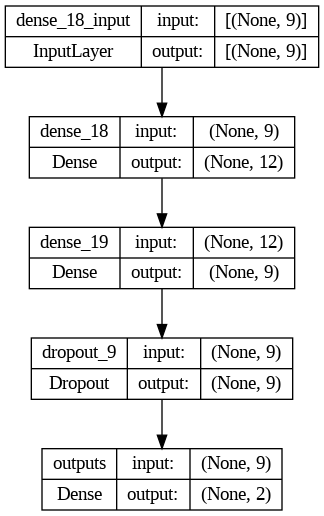

In [ ]:
# Total number of labels to predict (equal to the network output nodes)
num_classes = y_train_encoded.shape[1]

model = Sequential([
  layers.Dense(12, activation='relu', input_shape=(X_train.shape[1],)),
  layers.Dense(9, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='sigmoid', name="outputs")
])

adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999) # Thuật toán tối ưu
model.compile(
    loss='categorical_crossentropy', # Function tính loss function
    metrics=['accuracy'], # hiển thị xác suất độ chính xác
    optimizer=adam)
# Display model architecture summary
model.summary()
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB'
)

In [ ]:
(125*(11/12))/32

3.5807291666666665

In [ ]:
num_epochs = 1000
num_batch_size = 32
model_file = 'model_Colab1.h5'
model_path = os.path.join(ROOT_PATH, r'models', model_file)

os.makedirs(os.path.dirname(model_path), exist_ok=True)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path,
                               verbose=1,
                               save_best_only=True)
start = datetime.datetime.now()
history = model.fit(X_train,
                    y_train_encoded,
                    batch_size=num_batch_size,
                    epochs=num_epochs,
                    validation_split=1/12.,
                    callbacks=[checkpointer],
                    verbose=1)
duration = datetime.datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/1000
1/4 [======>.......................] - ETA: 2s - loss: 0.8875 - accuracy: 0.3750
Epoch 1: val_loss improved from inf to 0.30348, saving model to /content/drive/MyDrive/Document/EdgeAI/Data/FallDetection/models/model_Colab1.h5
4/4 [==============================] - 1s 172ms/step - loss: 0.8519 - accuracy: 0.4123 - val_loss: 0.3035 - val_accuracy: 1.0000
Epoch 2/1000
1/4 [======>.......................] - ETA: 0s - loss: 1.0598 - accuracy: 0.2500
Epoch 2: val_loss did not improve from 0.30348
4/4 [==============================] - 0s 23ms/step - loss: 0.8243 - accuracy: 0.3947 - val_loss: 0.3042 - val_accuracy: 1.0000
Epoch 3/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.7297 - accuracy: 0.4688
Epoch 3: val_loss did not improve from 0.30348
4/4 [==============================] - 0s 17ms/step - loss: 0.8278 - accuracy: 0.4123 - val_loss: 0.3049 - val_accuracy: 1.0000
Epoch 4/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.8662 - accuracy: 0.3750


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


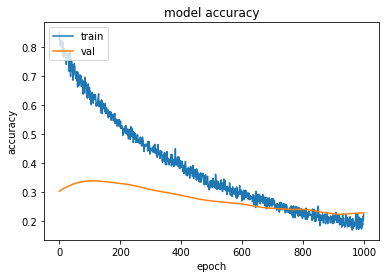

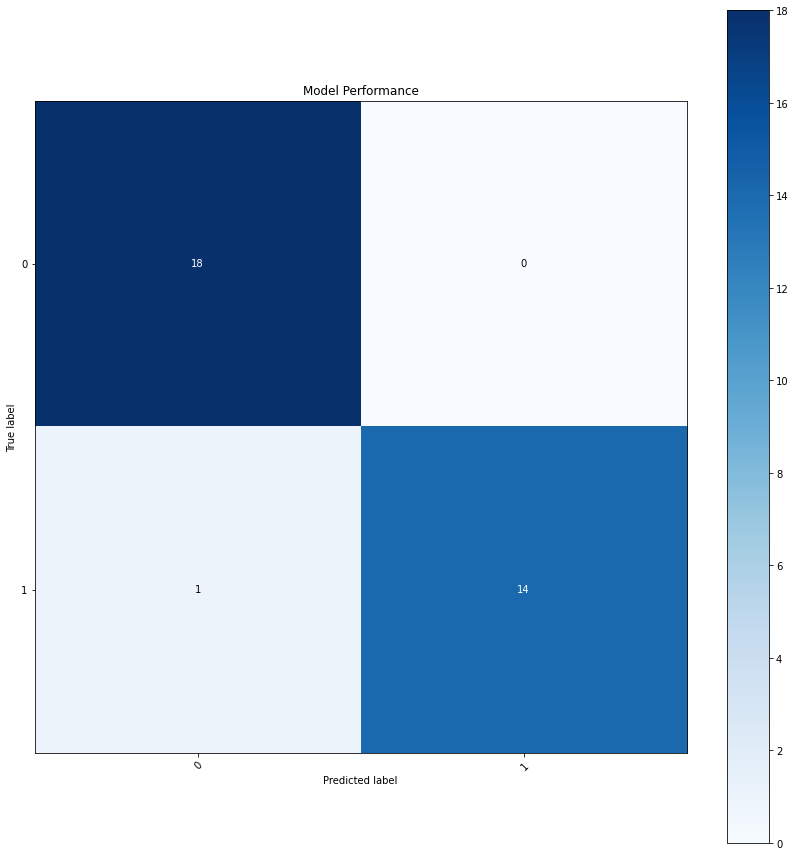

In [ ]:
model = load_model(model_path)

# include.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0) # 490, 30, 32, 1 <= 30, 32
# => 490, 10
# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1) # [0, 1, 0, 0, 0 ,0 ,0 ,0 ,0 ] => 1
y_trues = np.argmax(y_test_encoded, axis=1) # [0, 0, 1, 0, 0 ,0 ,0 ,0 ,0 ] => 2

# Add "pred" column
#test_meta['pred'] = yhat_probs

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

include.plot_confusion_matrix(cm,
                          labels,
                          normalized=False,
                          title="Model Performance",
                          cmap=plt.cm.Blues,
                          size=(12, 12))